In [44]:
%matplotlib inline
import pandas as pd
import json
import glob
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('text', usetex=True)

def name_cleaner(x):
    if '(' in x:
        return x.split(' ')[-1].strip('()').lstrip('()')
    else:
        return x

In [84]:
node_trans = pd.read_csv('../../data/group_names_trans.csv')
node_trans['nx_name'] = node_trans.AbmGTDname.apply(name_cleaner)

for country in ['Afghanistan', 'Iraq', 'Colombia']:
    #Load the multihawkes results
    multi = json.load( open('r1000/%s_multihawkes.json' % country) )
    #Get the names
    temp = pd.read_csv('../../data/%s_multihawkes_data.csv' % country, index_col=0)
    names = temp.iloc[:, 1:].columns.values.tolist()
    #recreate the network
    edges = []
    for gname in names:
        for i, w in enumerate(multi[gname]['W']):
            if w!=0:
                edges.append([name_cleaner(gname), name_cleaner(names[i]), w])
    #Write the network
    with open('../../results/multihawkes/r1000/%s_edges.csv' % country, 'w') as wfile:
        print('Source,Target,Weight', file=wfile)
        for i,j,w in edges:
            print('%s,%s,%f' % (i, j, w), file=wfile)
    G = nx.Graph()
    G.add_weighted_edges_from(edges)
    #Create the nodelist
    nodelist = set(node_trans[node_trans.country_txt == country].nx_name.values.tolist()).intersection(G.nodes())
    #Subset the graph
    sG = G.subgraph(nodelist)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    weights = [sG[u][v]['weight']*5 for u,v in sG.edges()]
    pos = nx.spring_layout(sG)
    nx.draw(sG, pos=pos, node_size=1000, 
            nodelist = nodelist, 
            arrows=True, 
            arrowstyle='>', with_labels=True, 
            node_color='steelblue', width=weights, ax=ax)
    plt.tight_layout()
    plt.savefig('../../results/multihawkes/r1000/%s.eps' % country)
    plt.savefig('../../results/multihawkes/r1000/%s.png' % country)

FileNotFoundError: [Errno 2] No such file or directory: 'r1000/Afghanistan_multihawkes.json'

In [17]:
countries = ['Afghanistan', 'Iraq', 'Colombia']
hawkes_edges = {c:pd.read_csv('../../results/multihawkes/r1000/%s_edges.csv' % c) for c in countries}
hawkes_edges['Source'] = hawkes_edges['Source'].apply(name_cleaner)

In [18]:
known_edges = {c:pd.read_csv('../../data/%s_edges.csv' % c) for c in countries}

In [19]:
name_trans = pd.read_csv('../../data/group_names_trans.csv')

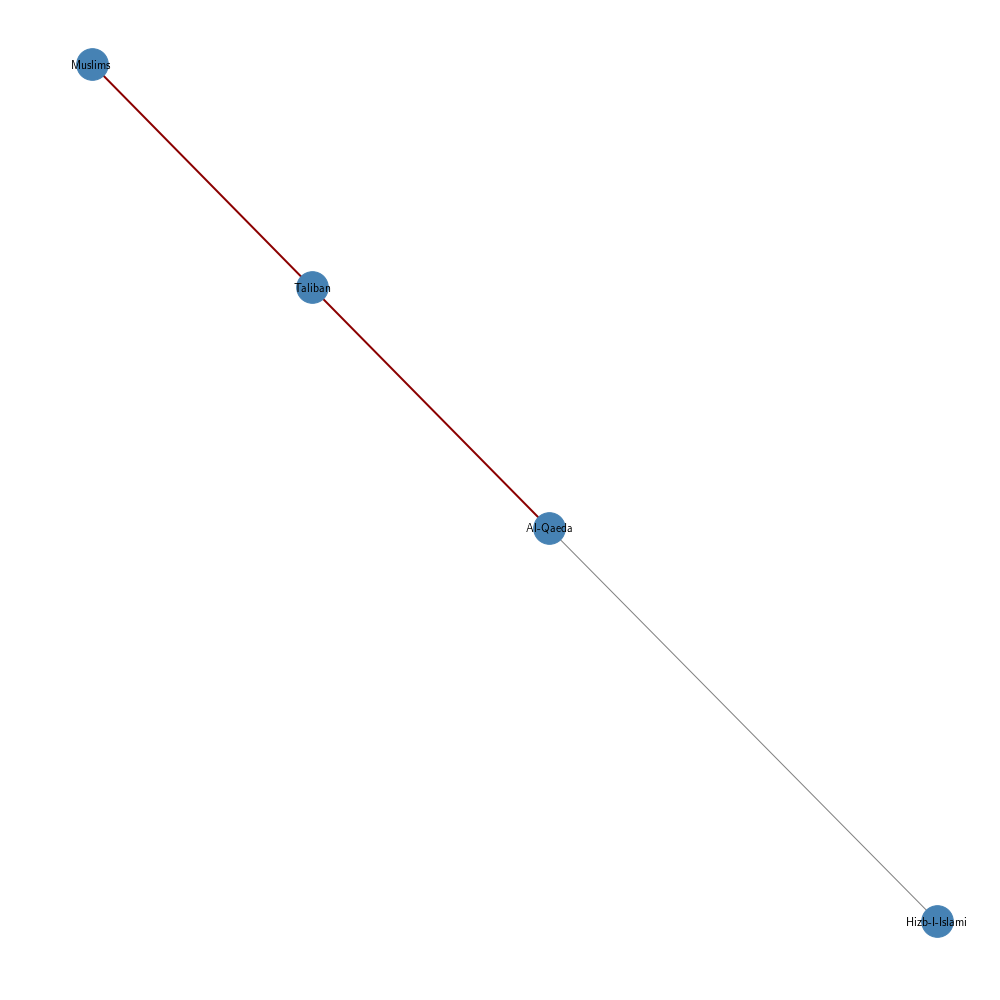

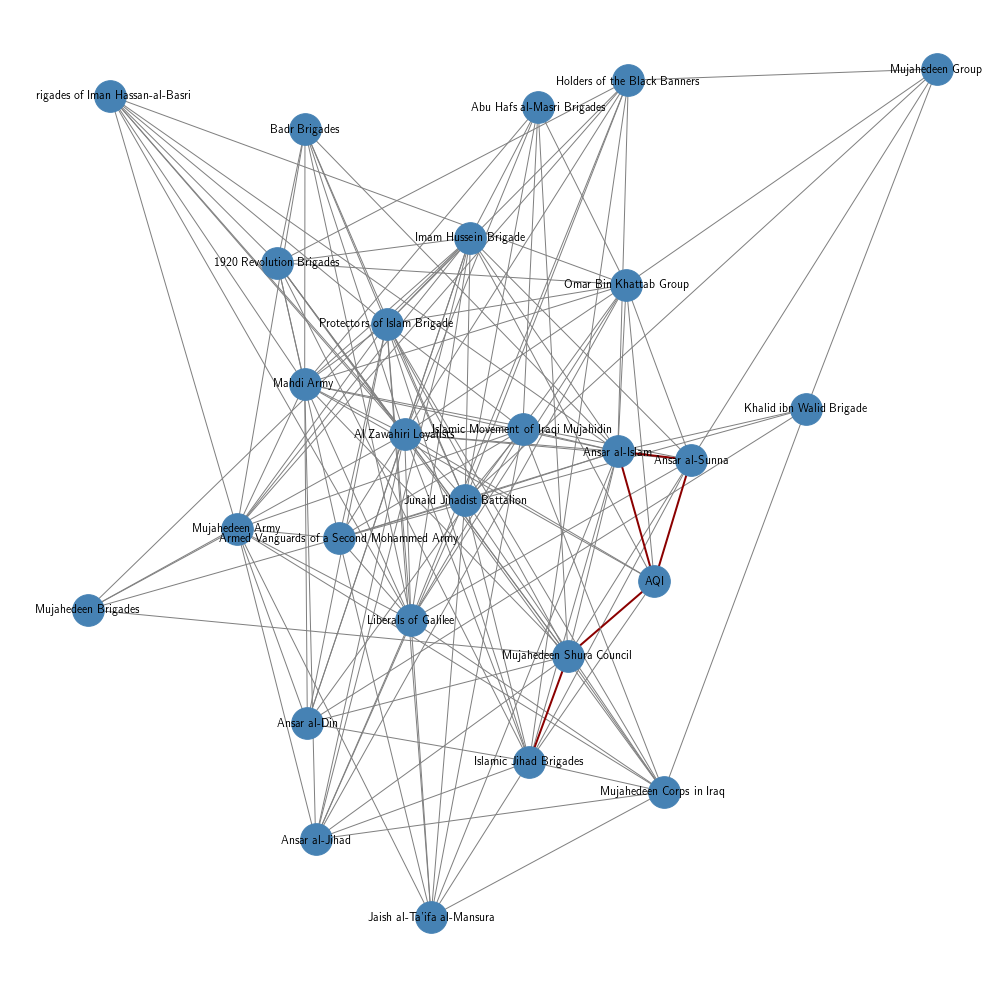

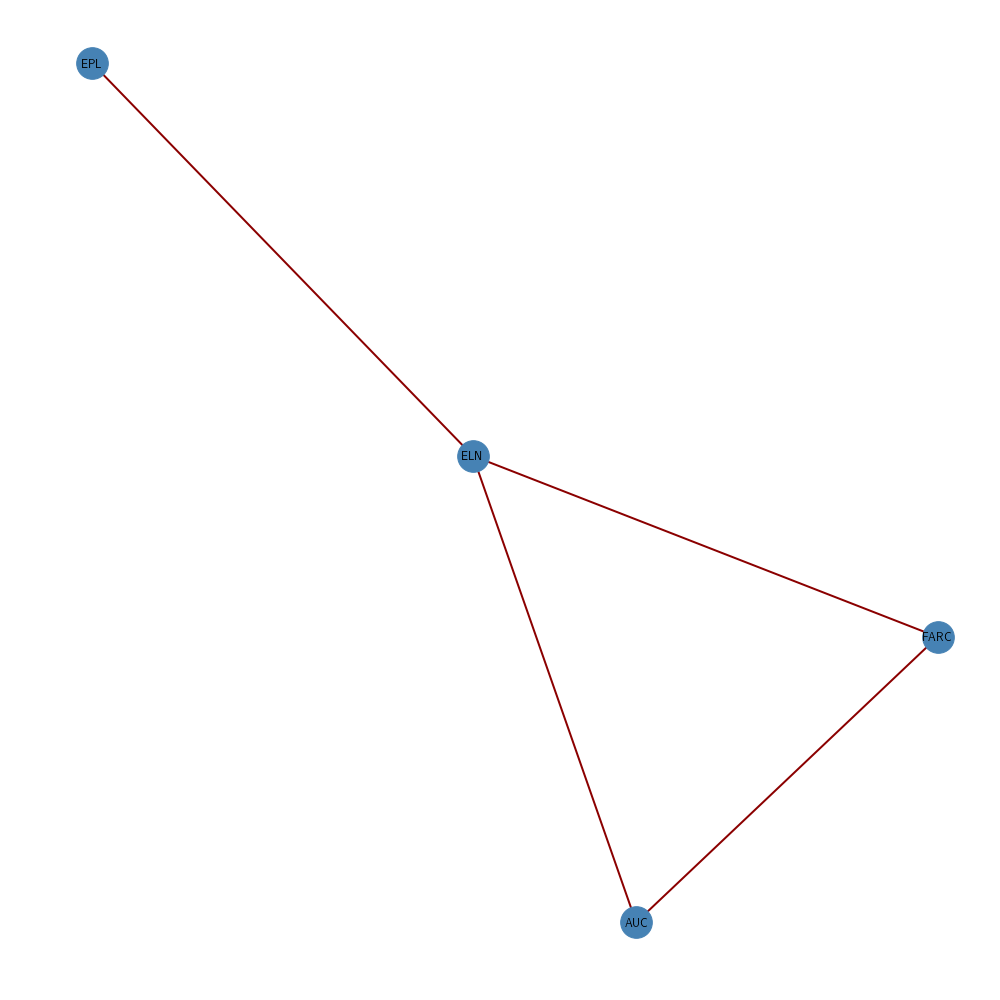

In [46]:
for country in countries:
    #Hawkes graph
    hawkes_G = nx.Graph()
    hawkes_G.add_weighted_edges_from( hawkes_edges[country].values.tolist() )
    #allied graph
    known_edges[country]['Weight']=1
    known_G = nx.Graph()
    known_G.add_weighted_edges_from( known_edges[country].values.tolist() )
    #Graph intersection
    full_graph = nx.compose(hawkes_G, known_G)
    #Subset it
    sub_full = full_graph.subgraph(name_trans.gname.values.tolist())
    #Plot it out
    fig = plt.figure(figsize=(14,14))
    ax = fig.add_subplot(111)
    pos = nx.spring_layout(sub_full)
    edge_coloring, edge_widths = [], []
    for edge in sub_full.edges():
        if edge in known_G.edges():
            edge_coloring.append('darkred')
            edge_widths.append(2)
        else:
            edge_coloring.append('gray')
            edge_widths.append(1)
    node_labels = {n:name_cleaner(n) for n in sub_full.nodes()}
    nx.draw(sub_full, pos=pos, node_size=1000, 
            with_labels=True, edge_color = edge_coloring, width = edge_widths, labels=node_labels,
            node_color='steelblue', ax=ax)
    plt.tight_layout()
    plt.savefig('../../results/multihawkes/r1000/%s_intersection.eps' % country)
    plt.savefig('../../results/multihawkes/r1000/%s_intersection.png' % country)